# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution
from src.timetabling_problem import MPTT

from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from mealpy.evolutionary_based import GA
from mealpy import IntegerVar
from pathlib import Path
import shutil
from typing import Any, List, Mapping, Tuple, Union

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)

Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
frame_capacity = {'1': 0.3, '2': 0.25, '3': 0.2, '4': 0.15, '5': 0.1}

n_services = 50
n_services_by_ru = {ru: round(cap * n_services) for ru, cap in frame_capacity.items()}

n_services_by_ru

{'1': 15, '2': 12, '3': 10, '4': 8, '5': 5}

In [4]:
seed = 21

if generator_config_path:
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(output_path=generator_save_path,
                           path_config=generator_config_path,
                           n_services_by_ru=n_services_by_ru,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 50


In [5]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)
print(tsp_df)

     Number of Services
RU1                  15
RU2                  12
RU3                  10
RU4                   8
RU5                   5


In [6]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = list(supply.lines)
line = infer_line_stations(lines)

Services:  50


In [7]:
n_services = sum(tsp_df["Number of Services"].values)

services_by_ru = {}
for service in revenue_behavior:
    if revenue_behavior[service]['ru'] not in services_by_ru:
        services_by_ru[revenue_behavior[service]['ru']] = 1
    else:
        services_by_ru[revenue_behavior[service]['ru']] += 1

services_by_ru = {f"RU{k}": v for k, v in services_by_ru.items()}
print(services_by_ru)

frame_capacity = {ru: round(services_by_ru[ru] / n_services * 100, 2) for ru in services_by_ru}
print(frame_capacity)

{'RU1': 15, 'RU2': 12, 'RU3': 10, 'RU4': 8, 'RU5': 5}
{'RU1': 30.0, 'RU2': 24.0, 'RU3': 20.0, 'RU4': 16.0, 'RU5': 10.0}


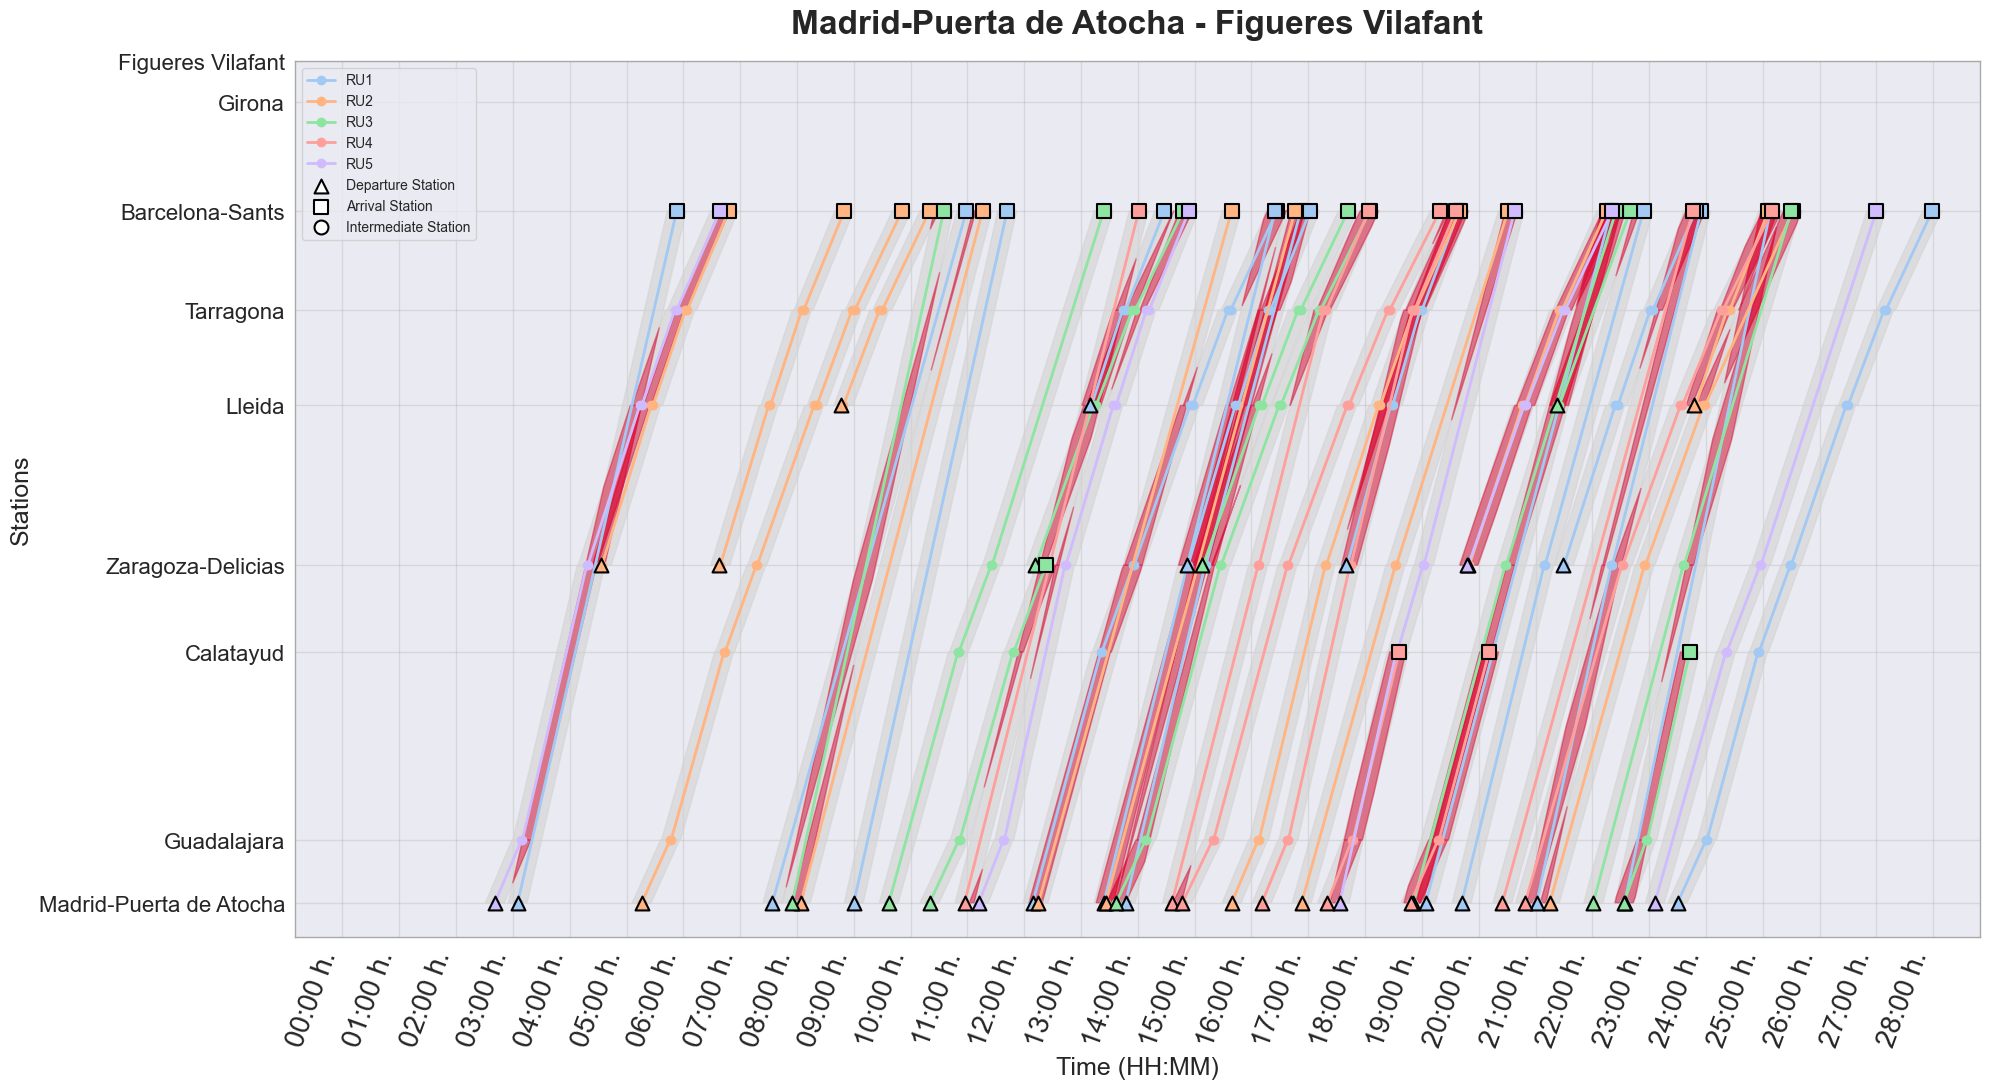

In [8]:
import datetime

date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=supply,
    date=date,
    save_path='../figures/escim2025/'
)

## 1. Mealpy

In [9]:
alpha_values = {"Revenue": 1, "Jain": 25, "Gini": 10, "Atkinson": 25}

## 2. Results analysis

In [10]:
reports_path = Path('../reports/mealpy/')
file_name = "opti_alpha_semi_balanced"

In [11]:
df_history = pd.read_csv(reports_path / f'df_history_equity_{file_name}.csv', sep=";")
df_population = pd.read_csv(reports_path / f'df_population_equity_{file_name}.csv', sep=";")

In [12]:
df_history

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,2172.051246,0.875966,[False True False True False False False Tr...,[1107. 1109. 1144. 1368. 1443. 1501. 1535. 159...,12.130909,0.000000,100.000000
1,1,Revenue,1,2393.917829,0.865383,[False True False False False False False Tr...,[1107. 1109. 1147. 1396. 1443. 1501. 1535. 159...,11.349545,6.441097,93.558903
2,1,Revenue,2,2760.493201,0.887021,[False True True True False False False Tr...,[1121. 1115. 1144. 1434. 1450. 1505. 1539. 159...,10.346515,14.709482,85.290518
3,1,Revenue,3,3079.196282,0.875909,[ True True False True False False False Tr...,[1095. 1115. 1148. 1434. 1445. 1505. 1539. 159...,9.393939,22.561950,77.438050
4,1,Revenue,4,3410.657550,0.864926,[False True False True False False False Tr...,[1078. 1113. 1144. 1434. 1441. 1500. 1535. 159...,8.071515,33.463229,66.536771
...,...,...,...,...,...,...,...,...,...,...
1995,5,Atkinson,95,4740.043403,0.879769,[ True False True True True False True Fal...,[1058. 1112. 1146. 1386. 1446. 1502. 1534. 159...,2.976364,74.641124,25.358876
1996,5,Atkinson,96,4740.043403,0.871687,[ True False True True True False True Fal...,[1058. 1112. 1146. 1386. 1446. 1502. 1534. 159...,2.477273,78.893421,21.106579
1997,5,Atkinson,97,4740.043403,0.879473,[ True False True True True False True Fal...,[1058. 1112. 1146. 1386. 1446. 1502. 1534. 159...,2.495303,78.739802,21.260198
1998,5,Atkinson,98,4740.043403,0.875531,[ True False True True True False True Fal...,[1058. 1112. 1146. 1386. 1446. 1502. 1534. 159...,2.168636,81.523030,18.476970


In [13]:
df_population


,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,[1102. 1114. 1146. 1415. 1450. 1505. 1531. 159...,[1030. 1111. 1142. 1454. 1441. 1500. 1536. 159...,[1107. 1109. 1146. 1368. 1443. 1501. 1539. 159...,[1076. 1115. 1144. 1416. 1442. 1503. 1535. 159...,[1016. 1111. 1143. 1393. 1442. 1496. 1538. 159...,[1035. 1113. 1148. 1434. 1445. 1497. 1539. 159...,[1035. 1111. 1143. 1434. 1442. 1496. 1539. 159...,...,[False True False False False False False Tr...,[False True False False False False False Tr...,[ True True False False False False False Tr...,[ True True False False False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Tr...,[ True True False True False False False Tr...,[False True False False False False False Fal...,[False True False True False False False Tr...
1,1,Revenue,1,[1025. 1111. 1146. 1454. 1450. 1500. 1531. 159...,[1033. 1112. 1143. 1405. 1449. 1502. 1530. 159...,[1035. 1117. 1148. 1399. 1450. 1501. 1538. 159...,[1076. 1113. 1146. 1434. 1445. 1497. 1539. 159...,[1078. 1113. 1148. 1416. 1441. 1500. 1531. 159...,[1025. 1115. 1146. 1454. 1442. 1503. 1539. 159...,[1115. 1113. 1146. 1454. 1441. 1497. 1539. 159...,...,[False True False True False False False Tr...,[False True True True False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Fal...,[False True False False False False False Tr...,[False True False True False True False Tr...,[False True False False False False False Fal...,[False True False False False False False Tr...,[False True False True False False False Fal...
2,1,Revenue,2,[1033. 1112. 1143. 1405. 1449. 1502. 1530. 159...,[1107. 1113. 1147. 1409. 1443. 1497. 1531. 159...,[1107. 1109. 1147. 1396. 1443. 1505. 1531. 159...,[1107. 1109. 1146. 1415. 1450. 1501. 1535. 159...,[1035. 1115. 1146. 1454. 1450. 1500. 1531. 159...,[1025. 1111. 1148. 1434. 1450. 1505. 1539. 159...,[1025. 1113. 1148. 1434. 1450. 1500. 1539. 159...,...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True False True False True False Tr...,[False True False True False False False Fal...,[False True False True False False False Tr...,[ True True False True False False False Fal...,[False True True False False False False Tr...,[False True False True False False False Tr...,[False True False True False True False Fal...,[False True False True False False False Fal...
3,1,Revenue,3,[1121. 1114. 1144. 1434. 1445. 1497. 1539. 159...,[1078. 1113. 1144. 1434. 1446. 1500. 1535. 159...,[1121. 1111. 1144. 1454. 1450. 1500. 1531. 159...,[1025. 1115. 1146. 1434. 1450. 1505. 1539. 159...,[1035. 1114. 1144. 1434. 1446. 1500. 1531. 159...,[1121. 1115. 1146. 1426. 1450. 1500. 1535. 159...,[1035. 1115. 1146. 1434. 1450. 1500. 1539. 159...,...,[False True False False False True False Fal...,[False True False True False True False Tr...,[False True False True False False False Tr...,[ True True False True False False False Tr...,[False True True True False False False Tr...,[False True False True False False False Fal...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True True True False False False Tr...,[ True True False True False False False Tr...
4,1,Revenue,4,[1121. 1113. 1144. 1434. 1445. 1497. 1533. 159...,[1095. 1115. 1144. 1434. 1450. 1505. 1539. 159...,[1095. 1114. 1148. 1396. 1446. 1500. 1538. 159...,[1078. 1113. 1144. 1434. 1441. 1500. 1535. 159...,[1025. 1115. 1144. 1434. 1450. 1505. 1531. 159...,[1102. 1115. 1148. 1434. 1445. 1505. 1531. 159...,[1095. 1114. 1148. 1396. 1441. 1500. 1531. 159...,...,[False True True False False False False Tr...,[False True False True

In [14]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,"[1102.0, 1114.0, 1146.0, 1415.0, 1450.0, 1505....","[1030.0, 1111.0, 1142.0, 1454.0, 1441.0, 1500....","[1107.0, 1109.0, 1146.0, 1368.0, 1443.0, 1501....","[1076.0, 1115.0, 1144.0, 1416.0, 1442.0, 1503....","[1016.0, 1111.0, 1143.0, 1393.0, 1442.0, 1496....","[1035.0, 1113.0, 1148.0, 1434.0, 1445.0, 1497....","[1035.0, 1111.0, 1143.0, 1434.0, 1442.0, 1496....",...,[False True False False False False False Tr...,[False True False False False False False Tr...,[ True True False False False False False Tr...,[ True True False False False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Tr...,[ True True False True False False False Tr...,[False True False False False False False Fal...,[False True False True False False False Tr...
1,1,Revenue,1,"[1025.0, 1111.0, 1146.0, 1454.0, 1450.0, 1500....","[1033.0, 1112.0, 1143.0, 1405.0, 1449.0, 1502....","[1035.0, 1117.0, 1148.0, 1399.0, 1450.0, 1501....","[1076.0, 1113.0, 1146.0, 1434.0, 1445.0, 1497....","[1078.0, 1113.0, 1148.0, 1416.0, 1441.0, 1500....","[1025.0, 1115.0, 1146.0, 1454.0, 1442.0, 1503....","[1115.0, 1113.0, 1146.0, 1454.0, 1441.0, 1497....",...,[False True False True False False False Tr...,[False True True True False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Fal...,[False True False False False False False Tr...,[False True False True False True False Tr...,[False True False False False False False Fal...,[False True False False False False False Tr...,[False True False True False False False Fal...
2,1,Revenue,2,"[1033.0, 1112.0, 1143.0, 1405.0, 1449.0, 1502....","[1107.0, 1113.0, 1147.0, 1409.0, 1443.0, 1497....","[1107.0, 1109.0, 1147.0, 1396.0, 1443.0, 1505....","[1107.0, 1109.0, 1146.0, 1415.0, 1450.0, 1501....","[1035.0, 1115.0, 1146.0, 1454.0, 1450.0, 1500....","[1025.0, 1111.0, 1148.0, 1434.0, 1450.0, 1505....","[1025.0, 1113.0, 1148.0, 1434.0, 1450.0, 1500....",...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True False True False True False Tr...,[False True False True False False False Fal...,[False True False True False False False Tr...,[ True True False True False False False Fal...,[False True True False False False False Tr...,[False True False True False False False Tr...,[False True False True False True False Fal...,[False True False True False False False Fal...
3,1,Revenue,3,"[1121.0, 1114.0, 1144.0, 1434.0, 1445.0, 1497....","[1078.0, 1113.0, 1144.0, 1434.0, 1446.0, 1500....","[1121.0, 1111.0, 1144.0, 1454.0, 1450.0, 1500....","[1025.0, 1115.0, 1146.0, 1434.0, 1450.0, 1505....","[1035.0, 1114.0, 1144.0, 1434.0, 1446.0, 1500....","[1121.0, 1115.0, 1146.0, 1426.0, 1450.0, 1500....","[1035.0, 1115.0, 1146.0, 1434.0, 1450.0, 1500....",...,[False True False False False True False Fal...,[False True False True False True False Tr...,[False True False True False False False Tr...,[ True True False True False False False Tr...,[False True True True False False False Tr...,[False True False True False False False Fal...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True True True False False False Tr...,[ True True False True False False False Tr...
4,1,Revenue,4,"[1121.0, 1113.0, 1144.0, 1434.0, 1445.0, 1497....","[1095.0, 1115.0, 1144.0, 1434.0, 1450.0, 1505....","[1095.0, 1114.0, 1148.0, 1396.0, 1446.0, 1500....","[1078.0, 1113.0, 1144.0, 1434.0, 1441.0, 1500....","[1025.0, 1115.0, 1144.0, 1434.0, 1450.0, 1505....","[1102.0, 1115.0, 1148.0, 1434.0, 1445.0, 1505....","[1095.0, 1114.0, 1148.0, 1396.0, 1441.0, 1500....",...

In [15]:
columns_to_transform = df_population.filter(like="discrete_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(lambda x: 1 if x == "True" else 0, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,"[1102.0, 1114.0, 1146.0, 1415.0, 1450.0, 1505....","[1030.0, 1111.0, 1142.0, 1454.0, 1441.0, 1500....","[1107.0, 1109.0, 1146.0, 1368.0, 1443.0, 1501....","[1076.0, 1115.0, 1144.0, 1416.0, 1442.0, 1503....","[1016.0, 1111.0, 1143.0, 1393.0, 1442.0, 1496....","[1035.0, 1113.0, 1148.0, 1434.0, 1445.0, 1497....","[1035.0, 1111.0, 1143.0, 1434.0, 1442.0, 1496....",...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."
1,1,Revenue,1,"[1025.0, 1111.0, 1146.0, 1454.0, 1450.0, 1500....","[1033.0, 1112.0, 1143.0, 1405.0, 1449.0, 1502....","[1035.0, 1117.0, 1148.0, 1399.0, 1450.0, 1501....","[1076.0, 1113.0, 1146.0, 1434.0, 1445.0, 1497....","[1078.0, 1113.0, 1148.0, 1416.0, 1441.0, 1500....","[1025.0, 1115.0, 1146.0, 1454.0, 1442.0, 1503....","[1115.0, 1113.0, 1146.0, 1454.0, 1441.0, 1497....",...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
2,1,Revenue,2,"[1033.0, 1112.0, 1143.0, 1405.0, 1449.0, 1502....","[1107.0, 1113.0, 1147.0, 1409.0, 1443.0, 1497....","[1107.0, 1109.0, 1147.0, 1396.0, 1443.0, 1505....","[1107.0, 1109.0, 1146.0, 1415.0, 1450.0, 1501....","[1035.0, 1115.0, 1146.0, 1454.0, 1450.0, 1500....","[1025.0, 1111.0, 1148.0, 1434.0, 1450.0, 1505....","[1025.0, 1113.0, 1148.0, 1434.0, 1450.0, 1500....",...,"[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
3,1,Revenue,3,"[1121.0, 1114.0, 1144.0, 1434.0, 1445.0, 1497....","[1078.0, 1113.0, 1144.0, 1434.0, 1446.0, 1500....","[1121.0, 1111.0, 1144.0, 1454.0, 1450.0, 1500....","[1025.0, 1115.0, 1146.0, 1434.0, 1450.0, 1505....","[1035.0, 1114.0, 1144.0, 1434.0, 1446.0, 1500....","[1121.0, 1115.0, 1146.0, 1426.0, 1450.0, 1500....","[1035.0, 1115.0, 1146.0, 1434.0, 1450.0, 1500....",...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
4,1,Revenue,4,"[1121.0, 1113.0, 1144.0, 1434.0, 1445.0, 1497....","[1095.0, 1115.0, 1144.0, 1434.0, 1450.0, 1505....","[1095.0, 1114.0, 1148.0, 1396.0, 1446.0, 1500....","[1078.0, 1113.0, 1144.0

In [16]:
# Transformar columnas con Real y Discrete después de leer el .csv
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behavior=revenue_behavior,
            line=line,
            safe_headway=10)

columns_to_transform = df_history.filter(like="Real").columns

# Sum 1 to Iteration column values
df_history['Iteration'] += 1

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(
        lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

# Incluir columnas con beneficio
df_history['Revenue'] = df_history['Real'].apply(mptt.objective_function)
df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,Revenue
0,1,Revenue,1,2172.051246,0.875966,"[False, True, False, True, False, False, False...","[1107, 1109, 1144, 1368, 1443, 1501, 1535, 159...",12.130909,0.000000,100.000000,2172.051246
1,1,Revenue,2,2393.917829,0.865383,"[False, True, False, False, False, False, Fals...","[1107, 1109, 1147, 1396, 1443, 1501, 1535, 159...",11.349545,6.441097,93.558903,2393.917829
2,1,Revenue,3,2760.493201,0.887021,"[False, True, True, True, False, False, False,...","[1121, 1115, 1144, 1434, 1450, 1505, 1539, 159...",10.346515,14.709482,85.290518,2760.493201
3,1,Revenue,4,3079.196282,0.875909,"[True, True, False, True, False, False, False,...","[1095, 1115, 1148, 1434, 1445, 1505, 1539, 159...",9.393939,22.561950,77.438050,3079.196282
4,1,Revenue,5,3410.657550,0.864926,"[False, True, False, True, False, False, False...","[1078, 1113, 1144, 1434, 1441, 1500, 1535, 159...",8.071515,33.463229,66.536771,3410.657550


In [17]:
# Function to compute fitness

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))


def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)


max_ineq = (len(ru_names) ** 2) / 4 if len(ru_names) % 2 == 0 else (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)


def pairwise_diff_from_discrete(scheduled_trains_array) -> float:
    # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
    importance_dict = mptt.sum_importance(scheduled_trains_array)
    importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

    # Calcular la suma de diferencias absolutas pairwise entre las importancias.
    pairwise_diff = 0
    for ru1, ru2 in itertools.combinations(ru_names, 2):
        pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

    return round(pairwise_diff / max_ineq * 100, 2)


def jain_index_from_discrete(scheduled, alpha) -> float:
    return mptt.jain_fairness_index(scheduled, mptt.capacities, alpha)[0]


def gini_index_from_discrete(scheduled, alpha) -> float:
    return mptt.gini_fairness_index(scheduled, mptt.capacities, alpha)[0]


def atkinson_index_from_discrete(scheduled, alpha) -> float:
    return mptt.atkinson_fairness_index(scheduled, mptt.capacities, alpha)[0]

In [18]:
import itertools

def get_plot_df(df: pd.DataFrame,
                map_function_selector: str = "Inequity") -> pd.DataFrame:
    filter_fair_index = ("Revenue", "Jain", "Gini", "Atkinson")

    # Create dataframe with fitness values for each individual of the population
    df_pop = df[df['FairIndex'].isin(filter_fair_index)]

    set_filtered_algos = set(df_pop["FairIndex"])
    print(f"Filtered algos: {set_filtered_algos}")

    df_pop = df_pop.replace(r'\n', ' ', regex=True)

    # Iterate through the dataframe and apply the function with progress feedback
    previous_run, previous_algo = None, None

    for index, row in df_pop.iterrows():
        current_run = row['Run']
        current_algo = row['FairIndex']
        real_solution = row

        # Print message if there's a change in 'Run' or 'FairIndex'
        if current_run != previous_run or current_algo != previous_algo:
            print(f"Processing new combination: Run = {current_run}, FairIndex = {current_algo}")
            previous_run, previous_algo = current_run, current_algo

        if map_function_selector == "Inequity":
            map_function = pairwise_diff_from_discrete
        else:
            # Apply the fitness function to the real columns
            if current_algo == "Jain":
                map_function = lambda x: jain_index_from_discrete(x, alpha_values[current_algo])
            elif current_algo == "Gini":
                map_function = lambda x: gini_index_from_discrete(x, alpha_values[current_algo])
            elif current_algo == "Atkinson":
                map_function = lambda x: atkinson_index_from_discrete(x, alpha_values[current_algo])
            else:
                map_function = lambda x: 1

        # Apply the fitness function to the real columns
        df_pop.loc[index, 'Inequity'] = map_function(row['Discrete'])

    print("Processing completed.")

    # Prepare dataframe for boxplot
    rows = []
    for row in df_pop.iterrows():
        run = row[1]['Run']
        iteration = row[1]['Iteration']
        fair_index = row[1]['FairIndex']

        inequity = row[1]['Inequity']
        rows.append({'Run': run, 'Iteration': iteration, 'Inequity': inequity, 'FairIndex': fair_index})

    return pd.DataFrame.from_dict(rows, orient='columns')

Filtered algos: {'Atkinson', 'Jain', 'Gini'}
Processing new combination: Run = 1, FairIndex = Jain
Processing new combination: Run = 2, FairIndex = Jain
Processing new combination: Run = 3, FairIndex = Jain
Processing new combination: Run = 4, FairIndex = Jain
Processing new combination: Run = 5, FairIndex = Jain
Processing new combination: Run = 1, FairIndex = Gini
Processing new combination: Run = 2, FairIndex = Gini
Processing new combination: Run = 3, FairIndex = Gini
Processing new combination: Run = 4, FairIndex = Gini
Processing new combination: Run = 5, FairIndex = Gini
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Processing new combination: Run = 3, FairIndex = Atkinson
Processing new combination: Run = 4, FairIndex = Atkinson
Processing new combination: Run = 5, FairIndex = Atkinson
Processing completed.


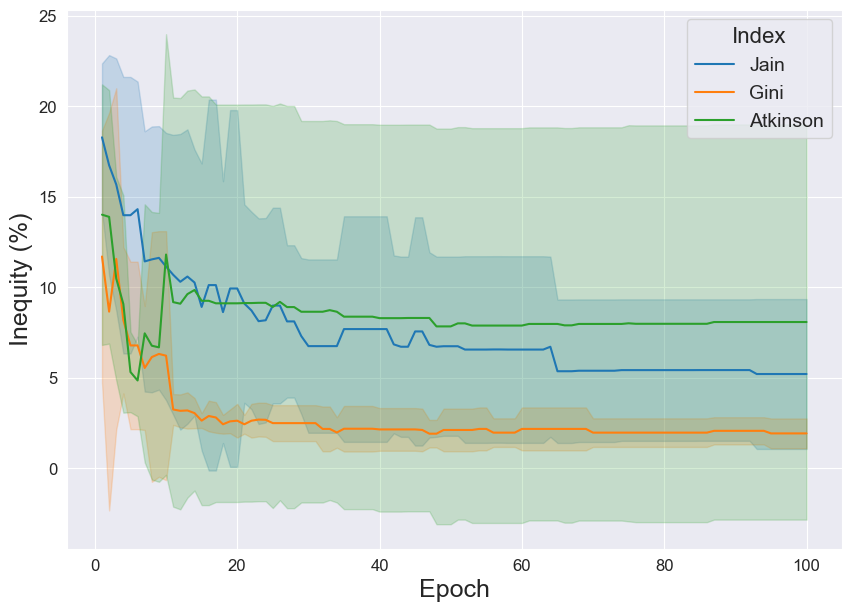

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

df_history_filtered = df_history[df_history['FairIndex'] != "Revenue"]

plt.figure(figsize=(10, 7))
sns.lineplot(
    data=get_plot_df(df_history_filtered, map_function_selector="Inequity"),
    x="Iteration",
    y="Inequity",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

"""
plt.title("Inequity evolution by epoch - Semi-balanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')
"""

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Inequity (%)", fontsize=18)

#plt.ylim((15, 30))

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Index", title_fontsize=16)

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/inequity_semibalanced_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

Filtered algos: {'Atkinson', 'Jain', 'Gini'}
Processing new combination: Run = 1, FairIndex = Jain
Processing new combination: Run = 2, FairIndex = Jain
Processing new combination: Run = 3, FairIndex = Jain
Processing new combination: Run = 4, FairIndex = Jain
Processing new combination: Run = 5, FairIndex = Jain
Processing new combination: Run = 1, FairIndex = Gini
Processing new combination: Run = 2, FairIndex = Gini
Processing new combination: Run = 3, FairIndex = Gini
Processing new combination: Run = 4, FairIndex = Gini
Processing new combination: Run = 5, FairIndex = Gini
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Processing new combination: Run = 3, FairIndex = Atkinson
Processing new combination: Run = 4, FairIndex = Atkinson
Processing new combination: Run = 5, FairIndex = Atkinson
Processing completed.


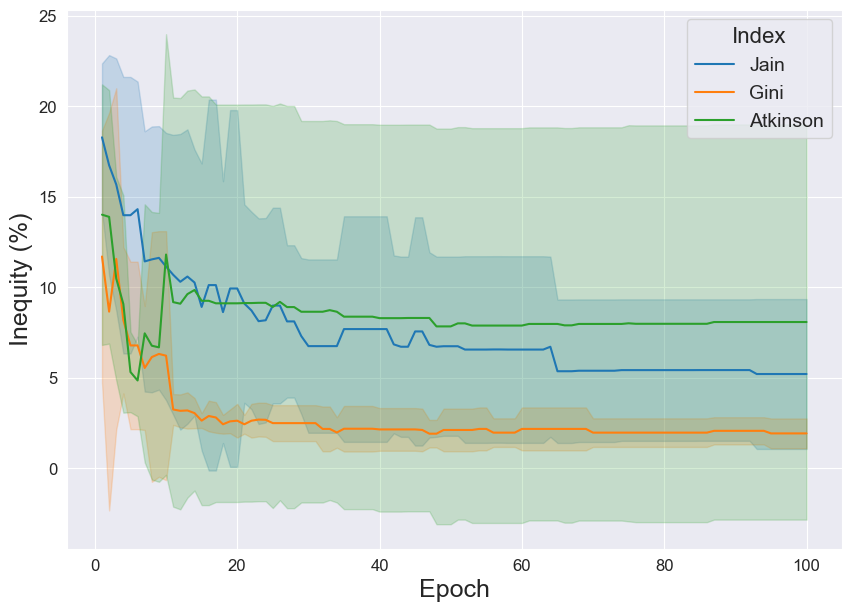

In [20]:
df_history_filtered = df_history[df_history['FairIndex'] != "Revenue"]

plt.figure(figsize=(10, 7))
sns.lineplot(
    data=get_plot_df(df_history_filtered, map_function_selector="Inequity"),
    x="Iteration",
    y="Inequity",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

"""
plt.title("Inequity evolution by epoch - Semi-balanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')
"""

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Inequity (%)", fontsize=18)

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Index", title_fontsize=16)

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/inequity_semibalanced_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

Filtered algos: {'Jain', 'Atkinson', 'Gini'}
Processing new combination: Run = 1, FairIndex = Jain
Processing new combination: Run = 2, FairIndex = Jain
Processing new combination: Run = 3, FairIndex = Jain
Processing new combination: Run = 4, FairIndex = Jain
Processing new combination: Run = 5, FairIndex = Jain
Processing new combination: Run = 1, FairIndex = Gini
Processing new combination: Run = 2, FairIndex = Gini
Processing new combination: Run = 3, FairIndex = Gini
Processing new combination: Run = 4, FairIndex = Gini
Processing new combination: Run = 5, FairIndex = Gini
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Processing new combination: Run = 3, FairIndex = Atkinson
Processing new combination: Run = 4, FairIndex = Atkinson
Processing new combination: Run = 5, FairIndex = Atkinson
Processing completed.


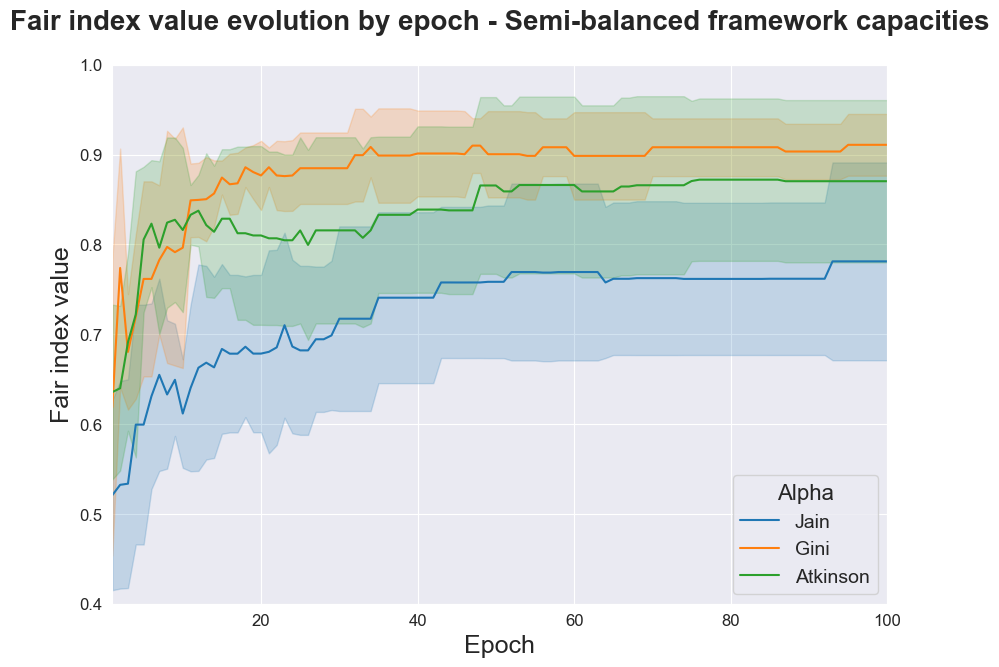

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

df_filtered = df_history[df_history['FairIndex'] != "Revenue"]

sns.lineplot(
    data=get_plot_df(df_filtered, map_function_selector="Revenue"),
    x="Iteration",
    y="Inequity",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

"""
plt.title("Fair index value evolution by epoch - Semi-balanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')
"""

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Fair index value", fontsize=18)

plt.tick_params(axis='both', labelsize=12)

plt.ylim((0.4, 1))
plt.xlim((1, 100))
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Index", title_fontsize=16, loc="lower right")

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/semibalanced_fair_index_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

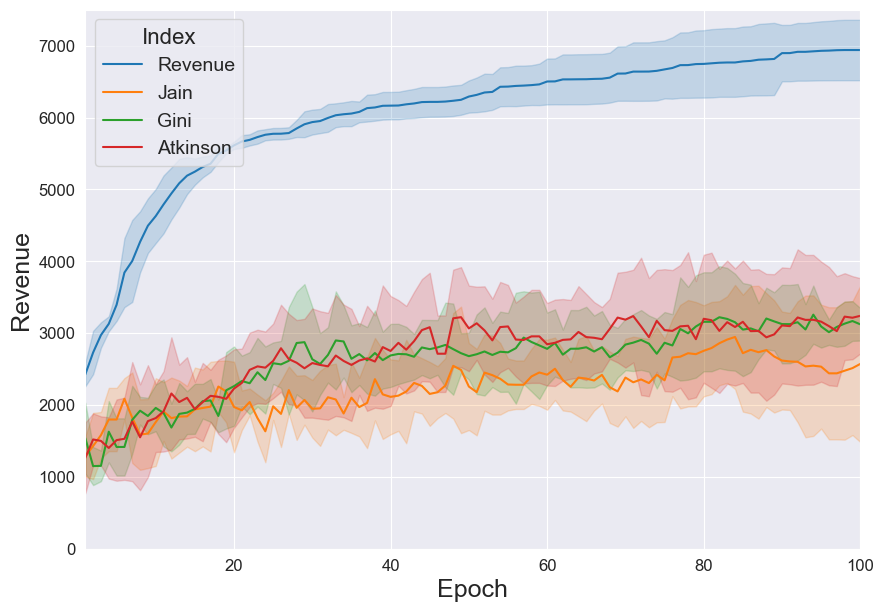

In [21]:
plt.figure(figsize=(10, 7))

df_filtered = df_history[df_history['FairIndex'] != "Revenue"]

sns.lineplot(
    data=df_history,
    x="Iteration",
    y="Revenue",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

"""
plt.title("Revenue evolution by epoch - Semi-balanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')
"""

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Revenue", fontsize=18)

plt.ylim((0, 7500))
plt.xlim((1, 100))

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Index", title_fontsize=16, loc="upper left")

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/revenue_semibalanced_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

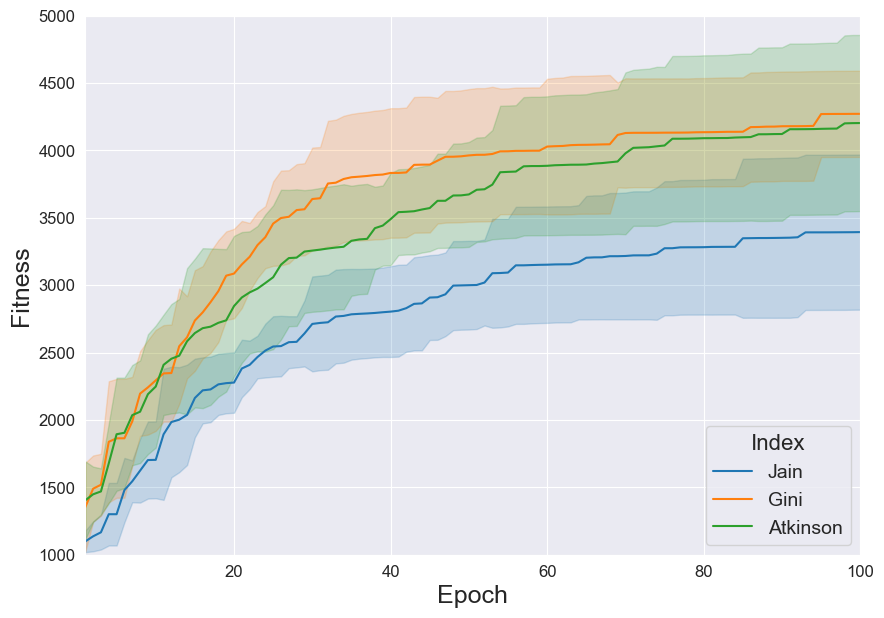

In [23]:
plt.figure(figsize=(10, 7))

df_filtered = df_history[df_history['FairIndex'] != "Revenue"]

sns.lineplot(
    data=df_filtered,
    x="Iteration",
    y="Fitness",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

"""
plt.title("Fitness evolution by epoch - Semi-balanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')
"""

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Fitness", fontsize=18)

plt.ylim((1000, 5000))
plt.xlim((1, 100))

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Index", title_fontsize=16, loc="lower right")

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/fitness_semibalanced_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [31]:
import itertools
import numpy as np
import pandas as pd

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Se asume que df_history tiene la columna 'Alpha'
# Además, se asume que ru_names y frame_capacity ya están definidos

# Definir las columnas del nuevo DataFrame (agregamos 'Alpha')
columns = ['FairIndex', 'Alpha', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains'] + ru_names + [
    'Total Importance', 'Inequity', 'Assigned capacity']
summary_df = pd.DataFrame(columns=columns)

# Agrupar el historial por FairIndex y luego por Run
algo_grouped_df = df_history.groupby('FairIndex')
for algo_key, algo_group in algo_grouped_df:
    run_grouped_df = algo_group.groupby('Run')
    for run_label, run_group in run_grouped_df:
        run = run_group['Run'].iloc[-1]
        # Extraemos el valor de Alpha (suponiendo que es constante en cada run)
        alpha = alpha_values[algo_key]
        fitness = np.round(run_group['Fitness'].iloc[-1], 2)
        revenue = mptt.objective_function(run_group['Real'].iloc[-1])
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizamos la planificación
        mptt.update_schedule(real_solution)

        # Obtener el diccionario de importancias (por RU)
        importance_dict = mptt.sum_importance(scheduled_trains_array)
        importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}
        total_importance = sum(importance_dict.values())

        # Calcular la suma de diferencias absolutas pairwise entre las importancias.
        pairwise_diff = 0
        for ru1, ru2 in itertools.combinations(ru_names, 2):
            pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

        # Se calcula max_ineq de acuerdo al número de RU (usado para normalizar la inequidad)
        if len(ru_names) % 2 == 0:
            max_ineq = (len(ru_names) ** 2) / 4
        else:
            max_ineq = (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)

        # Construir la fila de datos
        row_data = [
            algo_key,
            alpha,
            run,
            fitness,
            revenue,
            execution_time,
            scheduled_trains
        ]
        # Agregar, para cada RU, el valor de la importancia (en %)
        for ru in ru_names:
            row_data.append(round(importance_dict.get(ru, 0) * 100, 2))
        # Columna de Total Importance
        row_data.append(round(total_importance / len(ru_names) * 100, 2))
        # Columna de Inequity (normalizada)
        row_data.append(round(pairwise_diff / max_ineq * 100, 2))
        # Columna de Assigned capacity
        capacity_usage = 0.0
        for ru in ru_names:
            capacity_usage += importance_dict.get(ru, 0) * frame_capacity[ru]
        row_data.append(capacity_usage)

        summary_df.loc[len(summary_df)] = row_data

# Ordenamos o mostramos el DataFrame resumen si se desea
# display(summary_df)

# Ahora agrupamos por FairIndex y Alpha para obtener un resumen de la inequidad
df_summary = summary_df.groupby(['FairIndex', 'Alpha'])['Inequity'].agg(['mean', 'std']).reset_index()

# Opcional: redondeamos a dos decimales
df_summary[['mean', 'std']] = df_summary[['mean', 'std']].round(2)

print(df_summary)


  FairIndex  Alpha   mean    std
0  Atkinson     25   8.08  10.92
1      Gini     10   1.93   0.82
2      Jain     25   5.21   4.14
3   Revenue      1  26.06  11.28


In [32]:
import itertools

mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10,
    fair_index="Revenue",
    alpha=25
)

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Definir las columnas del nuevo DataFrame:
# FairIndex, Run, Revenue, Execution Time (s.), Scheduled Trains + una columna por cada RU
columns = ['FairIndex', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains'] + ru_names + [
    'Total Importance', 'Inequity', 'Assigned capacity']
summary_df = pd.DataFrame(columns=columns)

# Agrupar el historial por FairIndex y luego por Run
algo_grouped_df = df_history.groupby('FairIndex')

for algo_key, algo_group in algo_grouped_df:
    run_grouped_df = algo_group.groupby('Run')
    for run_label, run_group in run_grouped_df:
        run = run_group['Run'].iloc[-1]
        fitness = np.round(run_group['Fitness'].iloc[-1], 2)
        revenue = mptt.objective_function(run_group['Real'].iloc[-1])
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizamos la planificación (por si el método .sum_importance() depende de ello)
        mptt.update_schedule(real_solution)

        # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
        importance_dict = mptt.sum_importance(scheduled_trains_array)
        importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

        total_importance = sum(importance_dict.values())

        # Calcular la suma de diferencias absolutas pairwise entre las importancias.
        pairwise_diff = 0
        for ru1, ru2 in itertools.combinations(ru_names, 2):
            pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

        # Construir la fila de datos:
        row_data = [
            algo_key,
            run,
            fitness,
            revenue,
            execution_time,
            scheduled_trains
        ]

        # Agregar, para cada RU (ordenados alfabéticamente), el valor de suma de importancia.
        for ru in ru_names:
            # Si no existe valor para algún RU, se asigna 0
            row_data.append(round(importance_dict.get(ru, 0) * 100, 2))

        # Agregar la columna de Total Importance
        max_ineq = (len(ru_names) ** 2) / 4 if len(ru_names) % 2 == 0 else (len(ru_names) // 2) * (
                    (len(ru_names) + 1) // 2)
        row_data.append(round(total_importance / len(ru_names) * 100, 2))
        # Agregar la columna de Pairwise Differences
        row_data.append(round(pairwise_diff / max_ineq * 100, 2))

        capacity_usage = 0.0
        for ru in ru_names:
            capacity_usage += importance_dict.get(ru, 0) * frame_capacity[ru]
        row_data.append(capacity_usage)

        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Inequity', ascending=True)
display(summary_df)
print()

,FairIndex,Run,Fitness,Revenue,Execution Time (s.),Scheduled Trains,RU1,RU2,RU3,RU4,RU5,Total Importance,Inequity,Assigned capacity
9,Gini,5,4470.74,3150.580214,86.95,23,48.75,47.68,48.76,48.75,47.85,48.36,1.02,48.404274
7,Gini,3,4215.82,3038.500859,87.77,24,47.98,47.68,47.91,46.13,47.67,47.48,1.32,47.568363
14,Jain,5,3233.95,1288.704190,87.58,23,47.06,47.68,46.74,46.13,47.67,47.05,1.34,47.055571
0,Atkinson,1,4563.35,3644.525183,87.98,24,48.04,48.95,48.70,50.11,47.85,48.73,1.81,48.701994
5,Gini,1,4282.09,3383.599289,86.73,23,49.42,47.68,48.76,50.11,49.15,49.02,1.84,48.951643
8,Gini,4,3774.26,2788.019121,86.88,23,49.74,48.14,48.85,50.63,47.85,49.04,2.39,49.131787
12,Jain,3,4093.99,2414.823043,86.56,26,49.76,45.83,49.29,48.75,49.33,48.59,2.81,48.519161
2,Atkinson,3,4542.72,3233.685313,89.04,23,49.60,50.22,51.30,50.88,47.67,49.93,2.85,50.097106
6,Gini,2,4616.41,3252.631047,87.64,24,50.90,52.06,51.30,50.88,47.67,50.56,3.07,50.931010
3,Atkinson,4,4040.56,3249.853199,88.93,24,48.75,47.68,49.52,44.32,47.85,47.62,3.82,47.847718


In [33]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')

        print(f"Global {algo_group[0]} status:")

        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(
            f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')

        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')

        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')

        max_revenue = sum([mptt.revenue[service]['canon'] for service in mptt.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()


get_global_status(df_history)

Global Atkinson status:
	Total execution time: 4.4666 s.
	Execution Time (by run) - Mean: 0.8933 s. - Std: 0.012 s.
	Revenue - Mean: 4203.5782 - Std: 653.6023
	Scheduled Trains - Mean: 25.0 - Std: 2.0
	Max Revenue: 12045.0 - WARNING!: Scheduling all services could not be feasible

Global Gini status:
	Total execution time: 4.3578 s.
	Execution Time (by run) - Mean: 0.8716 s. - Std: 0.0077 s.
	Revenue - Mean: 4271.8651 - Std: 319.8112
	Scheduled Trains - Mean: 23.0 - Std: 1.0
	Max Revenue: 12045.0 - WARNING!: Scheduling all services could not be feasible

Global Jain status:
	Total execution time: 4.3943 s.
	Execution Time (by run) - Mean: 0.8789 s. - Std: 0.0125 s.
	Revenue - Mean: 3394.184 - Std: 575.5319
	Scheduled Trains - Mean: 25.0 - Std: 2.0
	Max Revenue: 12045.0 - WARNING!: Scheduling all services could not be feasible

Global Revenue status:
	Total execution time: 4.3004 s.
	Execution Time (by run) - Mean: 0.8601 s. - Std: 0.0256 s.
	Revenue - Mean: 6939.1019 - Std: 420.4492
	S

In [34]:
# Lista de columnas que queremos agregar (excluyendo 'FairIndex' que es la clave de agrupación)
columnas_agg = ['Fitness', 'Revenue', 'Execution Time (s.)'] + ru_names + ['Total Importance', 'Inequity',
                                                                           'Assigned capacity']

# Agrupamos por FairIndex y aplicamos las funciones de agregación 'mean' y 'std'
df_resultado = summary_df.groupby('FairIndex')[columnas_agg].agg(['mean', 'std'])

# Opcional: aplanamos los nombres de columnas para que queden en un formato más cómodo
df_resultado.columns = [f'{col[0]}_{col[1]}' for col in df_resultado.columns]
df_resultado.reset_index(inplace=True)

# Mostramos el dataframe resultante
display(df_resultado)

,FairIndex,Fitness_mean,Fitness_std,Revenue_mean,Revenue_std,Execution Time (s.)_mean,Execution Time (s.)_std,RU1_mean,RU1_std,RU2_mean,...,RU4_mean,RU4_std,RU5_mean,RU5_std,Total Importance_mean,Total Importance_std,Inequity_mean,Inequity_std,Assigned capacity_mean,Assigned capacity_std
0,Atkinson,4203.576,653.603982,3240.687543,523.830714,88.484,0.608301,51.738,4.506409,51.290,...,50.908,4.985566,50.428,5.865724,49.764,1.603178,8.084,10.920706,49.910970,1.679025
1,Gini,4271.864,319.811996,3122.666106,226.289970,87.194,0.475426,49.358,1.094998,48.648,...,49.300,1.954021,48.038,0.628108,48.892,1.128858,1.928,0.824542,48.997416,1.240257
2,Jain,3394.184,575.530932,2571.677421,1086.352055,87.176,0.837096,49.338,5.784256,49.260,...,50.626,8.249308,46.726,13.921720,49.266,8.866720,5.210,4.142336,49.473579,8.142496
3,Revenue,6939.100,420.447611,6939.101913,420.449187,85.708,0.617633,56.538,10.394011,57.608,...,70.714,2.736947,58.030,16.054968,57.708,2.445050,26.058,11.280154,57.033122,1.415453


In [35]:
# Orden deseado de FairIndex
orden_fairindex = ["Revenue", "Jain", "Gini", "Atkinson"]

# 1. Agrupamos y agregamos (media y desviación) para las columnas numéricas
columnas_agg = ['Fitness', 'Revenue', 'Execution Time (s.)'] + ru_names + ['Total Importance', 'Inequity',
                                                                           'Assigned capacity']
df_resultado = summary_df.groupby('FairIndex')[columnas_agg].agg(['mean', 'std'])

# 2. Aplanamos el MultiIndex de columnas para obtener nombres como 'Fitness_mean', 'Fitness_std', etc.
df_resultado.columns = [f'{col[0]}_{col[1]}' for col in df_resultado.columns]
df_resultado.reset_index(inplace=True)

# 3. Establecemos 'FairIndex' como índice y reordenamos según 'orden_fairindex'
df_resultado = df_resultado.set_index('FairIndex')
df_resultado = df_resultado.reindex(orden_fairindex)

# 4. Redondeamos todos los valores a dos decimales
df_resultado = df_resultado.round(2)

# 5. Transponemos el DataFrame para que las columnas se conviertan en filas
df_transpuesto = df_resultado.T

# 6. Convertimos el DataFrame transpuesto a tabla LaTeX
latex_table = df_transpuesto.to_latex(float_format='%.2f')

print(latex_table)

\begin{tabular}{lrrrr}
\toprule
FairIndex & Revenue & Jain & Gini & Atkinson \\
\midrule
Fitness_mean & 6939.10 & 3394.18 & 4271.86 & 4203.58 \\
Fitness_std & 420.45 & 575.53 & 319.81 & 653.60 \\
Revenue_mean & 6939.10 & 2571.68 & 3122.67 & 3240.69 \\
Revenue_std & 420.45 & 1086.35 & 226.29 & 523.83 \\
Execution Time (s.)_mean & 85.71 & 87.18 & 87.19 & 88.48 \\
Execution Time (s.)_std & 0.62 & 0.84 & 0.48 & 0.61 \\
RU1_mean & 56.54 & 49.34 & 49.36 & 51.74 \\
RU1_std & 10.39 & 5.78 & 1.09 & 4.51 \\
RU2_mean & 57.61 & 49.26 & 48.65 & 51.29 \\
RU2_std & 4.67 & 9.24 & 1.92 & 3.57 \\
RU3_mean & 45.64 & 50.39 & 49.12 & 44.47 \\
RU3_std & 15.42 & 8.21 & 1.28 & 13.33 \\
RU4_mean & 70.71 & 50.63 & 49.30 & 50.91 \\
RU4_std & 2.74 & 8.25 & 1.95 & 4.99 \\
RU5_mean & 58.03 & 46.73 & 48.04 & 50.43 \\
RU5_std & 16.05 & 13.92 & 0.63 & 5.87 \\
Total Importance_mean & 57.71 & 49.27 & 48.89 & 49.76 \\
Total Importance_std & 2.45 & 8.87 & 1.13 & 1.60 \\
Inequity_mean & 26.06 & 5.21 & 1.93 & 8.08 \\
Inequi

In [ ]:
def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')

    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')

        run_times = run_grouped_df['ExecutionTime'].sum()

        run_fitness = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)

        result = {
            'FairIndex': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness': round(run_fitness.mean(), 2),
            'Std Fitness': round(run_fitness.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
